In [1]:
import collections
import nest_asyncio

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from matplotlib import pyplot as plt

/usr/local/lib/python3.6/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:44: UserWarning: You are currently using a nightly version of TensorFlow (2.4.0-dev20200730). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  UserWarning,


In [2]:
nest_asyncio.apply()

In [3]:
tff.federated_computation(lambda: 'Hello, World!')()

b'Hello, World!'

### Prepping Input Data

Federated Datasets are non-iid, we will load them now

The data sets returned by load_data() are instances of tff.simulation.ClientData, an interface that allows us to enumerate the set of users, to construct a tf.data.Dataset that represents the data of a particular user, and to query the structure of individual elements. 

In [4]:
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

In [5]:
len(emnist_train.client_ids)

3383

In [6]:
emnist_train.element_type_structure

OrderedDict([('label', TensorSpec(shape=(), dtype=tf.int32, name=None)),
             ('pixels',
              TensorSpec(shape=(28, 28), dtype=tf.float32, name=None))])

In [7]:
example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0])

example_element = next(iter(example_dataset))

example_element['label'].numpy()

5

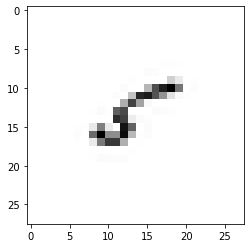

In [8]:
plt.imshow(example_element['pixels'].numpy(), cmap = 'gray', aspect = 'equal')
plt.grid(False)
_ = plt.show()

### Preprocessing

In [9]:
NUM_CLIENTS = 10
NUM_EPOCHS = 5
BATCH_SIZE = 20
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = 10

def preprocess(dataset):

  def batch_format_fn(element):
    """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
    return collections.OrderedDict(
        x = tf.reshape(element['pixels'], [-1, 784]),
        y = tf.reshape(element['label'], [-1, 1]))

  return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
      BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

In [10]:
preprocessed_example_dataset = preprocess(example_dataset)

sample_batch = tf.nest.map_structure(lambda x: x.numpy(),
                                     next(iter(preprocessed_example_dataset)))

sample_batch

OrderedDict([('x', array([[1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     ...,
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)),
             ('y', array([[6],
                     [7],
                     [7],
                     [7],
                     [5],
                     [2],
                     [1],
                     [7],
                     [7],
                     [1],
                     [2],
                     [1],
                     [6],
                     [0],
                     [3],
                     [3],
                     [0],
                     [9],
                     [4],
                     [6]], dtype=int32))])

In [11]:
def make_federated_data(client_data, client_ids):
  return [
      preprocess(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
  ]

### Random Sampling

In [12]:
sample_clients = emnist_train.client_ids[0:NUM_CLIENTS]

federated_train_data = make_federated_data(emnist_train, sample_clients)

print('Number of client datasets: {l}'.format(l = len(federated_train_data)))
print('First dataset: {d}'.format(d = federated_train_data[0]))

Number of client datasets: 10
First dataset: <PrefetchDataset shapes: OrderedDict([(x, (None, 784)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>


### Create Model

In order to use any model with TFF, it needs to be wrapped in an instance of the tff.learning.Model interface, which exposes methods to stamp the model's forward pass, metadata properties, etc., similarly to Keras, but also introduces additional elements, such as ways to control the process of computing federated metrics. 

In [13]:
def create_keras_model():
  return tf.keras.models.Sequential([
      tf.keras.layers.Input(shape = (784,)),
      tf.keras.layers.Dense(10, kernel_initializer = 'zeros'),
      tf.keras.layers.Softmax(),
  ])

In [14]:
def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.
  keras_model = create_keras_model()
  return tff.learning.from_keras_model(
      keras_model,
      input_spec = preprocessed_example_dataset.element_spec,
      loss = tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics = [tf.keras.metrics.SparseCategoricalAccuracy()])

### Training the Model

Now that we have a model wrapped as tff.learning.Model for use with TFF, we can let TFF construct a Federated Averaging algorithm by invoking the helper function tff.learning.build_federated_averaging_process.

One critical note on the Federated Averaging algorithm, there are 2 optimizers: a _clientoptimizer and a _serveroptimizer. The _clientoptimizer is only used to compute local model updates on each client. The _serveroptimizer applies the averaged update to the global model at the server. In particular, this means that the choice of optimizer and learning rate used may need to be different than the ones you have used to train the model on a standard i.i.d. dataset. We recommend starting with regular SGD, possibly with a smaller learning rate than usual.

In [15]:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn = lambda: tf.keras.optimizers.SGD(learning_rate = 0.02),
    server_optimizer_fn = lambda: tf.keras.optimizers.SGD(learning_rate = 1.0))

TFF has constructed a pair of federated computations above and packaged them into a tff.templates.IterativeProcess in which these computations are available as a pair of properties initialize and next.

In a nutshell, federated computations are programs in TFF's internal language that can express various federated algorithms (you can find more about this in the custom algorithms tutorial). In this case, the two computations generated and packed into iterative_process implement Federated Averaging.

It is a goal of TFF to define computations in a way that they could be executed in real federated learning settings, but currently only local execution simulation runtime is implemented. To execute a computation in a simulator, you simply invoke it like a Python function.

In [16]:
str(iterative_process.initialize.type_signature)

'( -> <model=<trainable=<float32[784,10],float32[10]>,non_trainable=<>>,optimizer_state=<int64>,delta_aggregate_state=<>,model_broadcast_state=<>>@SERVER)'

In [17]:
# Let's invoke the initialize computation to construct the server state.

state = iterative_process.initialize()

The second of the pair of federated computations, next, represents a single round of Federated Averaging, which consists of pushing the server state (including the model parameters) to the clients, on-device training on their local data, collecting and averaging model updates, and producing a new updated model at the server.

In [18]:
state, metrics = iterative_process.next(state, federated_train_data)
print('round  1, metrics={}'.format(metrics))

round  1, metrics=OrderedDict([('broadcast', ()), ('aggregation', ()), ('train', OrderedDict([('sparse_categorical_accuracy', 0.12489712), ('loss', 3.0671268)]))])


In [19]:
NUM_ROUNDS = 11
for round_num in range(2, NUM_ROUNDS):
  state, metrics = iterative_process.next(state, federated_train_data)
  print('round {:2d}, metrics={}'.format(round_num, metrics))

round  2, metrics=OrderedDict([('broadcast', ()), ('aggregation', ()), ('train', OrderedDict([('sparse_categorical_accuracy', 0.13168724), ('loss', 2.9448771)]))])
round  3, metrics=OrderedDict([('broadcast', ()), ('aggregation', ()), ('train', OrderedDict([('sparse_categorical_accuracy', 0.1574074), ('loss', 2.7820308)]))])
round  4, metrics=OrderedDict([('broadcast', ()), ('aggregation', ()), ('train', OrderedDict([('sparse_categorical_accuracy', 0.17901234), ('loss', 2.7028527)]))])
round  5, metrics=OrderedDict([('broadcast', ()), ('aggregation', ()), ('train', OrderedDict([('sparse_categorical_accuracy', 0.20596708), ('loss', 2.5382142)]))])
round  6, metrics=OrderedDict([('broadcast', ()), ('aggregation', ()), ('train', OrderedDict([('sparse_categorical_accuracy', 0.2037037), ('loss', 2.5803547)]))])
round  7, metrics=OrderedDict([('broadcast', ()), ('aggregation', ()), ('train', OrderedDict([('sparse_categorical_accuracy', 0.2462963), ('loss', 2.3873074)]))])
round  8, metrics=O

### Customizing the Model

tff.learning provides a lower-level model interface, tff.learning.Model, that exposes the minimal functionality necessary for using a model for federated learning. Directly implementing this interface (possibly still using building blocks like tf.keras.layers) allows for maximum customization without modifying the internals of the federated learning algorithms.

In [20]:
MnistVariables = collections.namedtuple(
    'MnistVariables', 'weights bias num_examples loss_sum accuracy_sum')

In [21]:
def create_mnist_variables():
  return MnistVariables(
      weights = tf.Variable(
          lambda: tf.zeros(dtype = tf.float32, shape = (784, 10)),
          name = 'weights',
          trainable = True),
      bias = tf.Variable(
          lambda: tf.zeros(dtype = tf.float32, shape = (10)),
          name = 'bias',
          trainable = True),
      num_examples = tf.Variable(0.0, name = 'num_examples', trainable = False),
      loss_sum = tf.Variable(0.0, name = 'loss_sum', trainable = False),
      accuracy_sum = tf.Variable(0.0, name = 'accuracy_sum', trainable = False))

In [22]:
def mnist_forward_pass(variables, batch):
  y = tf.nn.softmax(tf.matmul(batch['x'], variables.weights) + variables.bias)
  predictions = tf.cast(tf.argmax(y, 1), tf.int32)

  flat_labels = tf.reshape(batch['y'], [-1])
  loss = -tf.reduce_mean(
      tf.reduce_sum(tf.one_hot(flat_labels, 10) * tf.math.log(y), axis = [1]))
  accuracy = tf.reduce_mean(
      tf.cast(tf.equal(predictions, flat_labels), tf.float32))

  num_examples = tf.cast(tf.size(batch['y']), tf.float32)

  variables.num_examples.assign_add(num_examples)
  variables.loss_sum.assign_add(loss * num_examples)
  variables.accuracy_sum.assign_add(accuracy * num_examples)

  return loss, predictions

In [23]:
def get_local_mnist_metrics(variables):
  return collections.OrderedDict(
      num_examples = variables.num_examples,
      loss = variables.loss_sum / variables.num_examples,
      accuracy = variables.accuracy_sum / variables.num_examples)

In [24]:
@tff.federated_computation
def aggregate_mnist_metrics_across_clients(metrics):
  return collections.OrderedDict(
      num_examples = tff.federated_sum(metrics.num_examples),
      loss = tff.federated_mean(metrics.loss, metrics.num_examples),
      accuracy = tff.federated_mean(metrics.accuracy, metrics.num_examples))

### Constructing an instance of tff.learning.Model

In [25]:
class MnistModel(tff.learning.Model):

  def __init__(self):
    self._variables = create_mnist_variables()

  @property
  def trainable_variables(self):
    return [self._variables.weights, self._variables.bias]

  @property
  def non_trainable_variables(self):
    return []

  @property
  def local_variables(self):
    return [
        self._variables.num_examples, self._variables.loss_sum,
        self._variables.accuracy_sum
    ]

  @property
  def input_spec(self):
    return collections.OrderedDict(
        x = tf.TensorSpec([None, 784], tf.float32),
        y = tf.TensorSpec([None, 1], tf.int32))

  @tf.function
  def forward_pass(self, batch, training=True):
    del training
    loss, predictions = mnist_forward_pass(self._variables, batch)
    num_exmaples = tf.shape(batch['x'])[0]
    return tff.learning.BatchOutput(
        loss = loss, predictions = predictions, num_examples = num_exmaples)

  @tf.function
  def report_local_outputs(self):
    return get_local_mnist_metrics(self._variables)

  @property
  def federated_output_computation(self):
    return aggregate_mnist_metrics_across_clients